# Evaluate and compare explanations

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Reshape, Multiply
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.losses import kld

Using TensorFlow backend.


### Load and preprocess images

In [2]:
dir_path = '/scratch2/Datasets/imagenet100/val/'
files = os.listdir(dir_path)
N = len(files)

X = np.empty((N, 224, 224, 3))
for i, file in enumerate(files):
    x = load_img(dir_path + file, target_size=(224, 224))
    X[i] = img_to_array(x)
X = preprocess_input(X)

In [3]:
X_gray = X.mean(-1)

### Learning saliency

In [7]:
K.clear_session()
model = VGG16(include_top=True)
#exp_model = build_explanation_model(model, reg)
exp_model = load_model('exp_model_good.hdf5')
exp_model.layers[-1].trainable = False # Freeze VGG weights
l.activity_regularizer = l2(1e-7) # Set regularization coefficient

load = True
if load:
    # Load pretrained weights
    print('Loading weights')
    exp_model.load_weights('exp_model_good.hdf5')
    optimizer = SGD(lr=0.001)
else:
    # Tune from scratch
    optimizer = SGD(lr=0.01)
exp_model.compile(optimizer=optimizer, loss='kld')

saliency_fn = K.function(exp_model.inputs, [exp_model.get_layer('attention').output])

Loading weights


In [9]:
explanations = np.empty((X.shape[:-1]))
batch_size = 32
for i in range((N + batch_size - 1) // batch_size):
    start = i * batch_size
    end = min((i+1) * batch_size, N)
    explanations[start:end] = saliency_fn([X[start:end]])[0].reshape((end - start, 224, 224))

In [ ]:
explanations.tofile('explanations_raw.npy')

In [ ]:
explanations = np.empty((X.shape[:-1]))
K.clear_session()
model = VGG16(include_top=True)
exp_model = load_model('exp_model_good.hdf5', compile=False)
exp_model.layers[-1].trainable = False
optimizer = SGD(lr=0.001)
exp_model.compile(optimizer=optimizer, loss='kld')
saliency_fn = K.function(exp_model.inputs, [exp_model.get_layer('attention').output])    
for i in range(N):
    print(i)
    exp_model.load_weights('exp_model_good.hdf5')
    p = model.predict(X[i:i+1])
    hist = exp_model.fit(X[i:i+1], p, epochs=20, verbose=False)
    explanations[i] = saliency_fn([X[i:i+1]])[0].reshape((224, 224))

In [30]:
explanations.tofile('explanations_ft.npy')

In [11]:
scaled_explanations = explanations - explanations.mean(axis=(1, 2))[:, None, None]
scaled_explanations = np.maximum(scaled_explanations, 0)

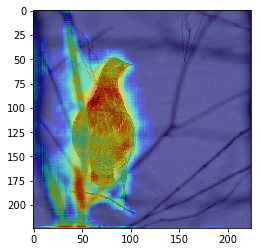

In [12]:
i = 37
plt.imshow(load_img(dir_path + files[i], target_size=(224, 224)))

sal = explanations[i]
sal -= sal.mean()
sal = np.maximum(0, sal)
plt.imshow(scaled_explanations[i], cmap='jet', alpha=0.5)
plt.show()

### Explanations evaluation

In [16]:
# Flip N pixels at a time, no reevaluation
def explanation_selectivity(imgs, explanations, N, blur=False):
    imgs_copy = imgs.copy()
    if blur:
        explanations = explanations.copy()
        for i in range(explanations.shape[0]):
            explanations[i] = gaussian(explanations[i])
        print('Blurring done')
    
    model = VGG16()
    predictions = model.predict(imgs_copy, batch_size=100)
    top = np.argmax(predictions, -1)
    n_steps = (224 * 224 + N - 1) // N
    hist = np.empty((n_steps + 1, imgs.shape[0]))
    hist[0] = predictions[range(5000), top]
    painting_order = np.flip(np.argsort(explanations.reshape(-1, 224*224), axis=1), axis=-1)    
    r = np.array(range(5000)).reshape(5000, 1)
    
    # While not all pixels are black
    for step in range(n_steps):
        sys.stdout.write('\r')    
        sys.stdout.write("[%-20s] %.0f%%" % ('='*int(step/n_steps * 20), 100*step/n_steps))
        sys.stdout.flush()
        coords = painting_order[:, N * step:N * (step + 1)]
        imgs_copy.reshape(5000, -1, 3)[r, coords] = 0
        hist[step + 1] = model.predict(imgs_copy, batch_size=100)[range(5000), top]
    sys.stdout.write('\r')
    sys.stdout.flush()
    print("[%-20s] %.0f%%" % ('='*20, 100))
    return hist

def auc(arr):
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

#### Run the evaluation for all necessary explanations here

In [ ]:
hist = explanation_selectivity(X, explanations, 28*7)
hist.tofile('hist_raw.npy')

#### Load generated histories

In [20]:
hist_raw = np.fromfile('hist_raw.npy').reshape(-1, 5000)
hist_ft = np.fromfile('hist_ft20.npy').reshape(-1, 5000)
hist_inten = np.fromfile('hist_intensities.npy').reshape(-1, 5000)
hist_gradcam = np.fromfile('hist_gradcam.npy').reshape(-1, 5000)
hist_guidedbackprop = np.fromfile('hist_gbp.npy').reshape(-1, 5000)

#### Plot results

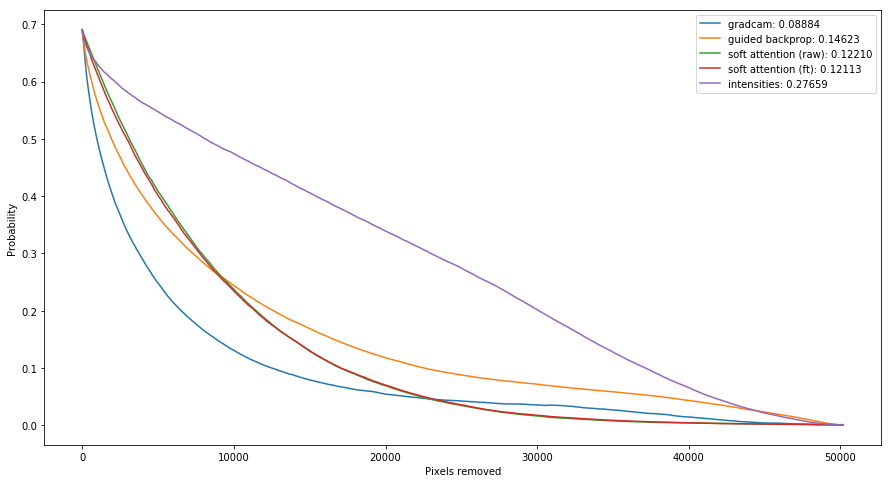

In [21]:
plt.figure(figsize=(15, 8))

n_steps = hist_gradcam.shape[0]
N = 28
plt.plot(N*np.arange(n_steps), hist_gradcam.mean(1))
plt.plot(N*np.arange(n_steps), hist_guidedbackprop.mean(1))
plt.plot(N*np.arange(n_steps), hist_raw.mean(1))
plt.plot(N*np.arange(n_steps), hist_ft.mean(1))
plt.plot(N*np.arange(n_steps), hist_inten.mean(1))

plt.legend(['gradcam: {:.5f}'.format(auc(hist_gradcam.mean(1))), 
            'guided backprop: {:.5f}'.format(auc(hist_guidedbackprop.mean(1))), 
            'soft attention (raw): {:.5f}'.format(auc(hist_raw.mean(1))), 
            'soft attention (ft): {:.5f}'.format(auc(hist_ft.mean(1))), 
            'intensities: {:.5f}'.format(auc(hist_inten.mean(1)))])
plt.xlabel('Pixels removed')
plt.ylabel('Probability')
plt.show()

#### Analyze drop in probability for particular image

In [32]:
def analyze(imgs, y, explanations, N, i):
    img_copy = imgs[i].copy().reshape(1, 224, 224, 3)
    imm = img_to_array(load_img(dir_path + files[i], target_size=(224, 224)))
    model = VGG16()
    predictions = model.predict(img_copy)[0]    
    top = np.argmax(predictions)
    n_steps = (224 * 224 + N - 1) // N
    hist = np.empty(n_steps + 1)
    hist[0] = predictions[top]    
    painting_order = np.flip(np.argsort(explanations[i].reshape(-1, 224*224), axis=1), axis=-1)    
    
    r = np.array(range(5000)).reshape(5000, 1)
    # While not all pixels are black
    for step in range(n_steps):
        print('Step {}/{}, P={}'.format(step, n_steps, hist[step]))
        plt.imshow(imm)
        plt.show()
        coords = painting_order[:, N * step:N * (step + 1)]
        img_copy.reshape(1, -1, 3)[0, coords] = 0
        imm.reshape(1, -1, 3)[0, coords] = 0
        hist[step + 1] = model.predict(img_copy)[0][top]
            
    print('Step {}/{}, P={}'.format(step, n_steps, hist[step]))
    plt.imshow(imm)
    plt.show()
    return hist

In [26]:
explanations = np.fromfile('explanations_ft.npy').reshape(-1, 224, 224)

Step 0/224, P=0.6250124573707581


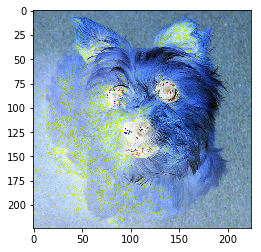

Step 1/224, P=0.5627377033233643


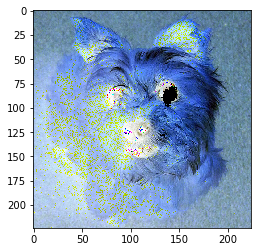

Step 2/224, P=0.43688419461250305


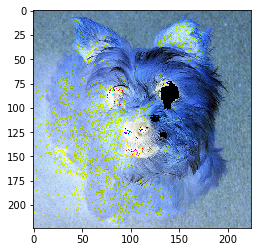

Step 3/224, P=0.4017123878002167


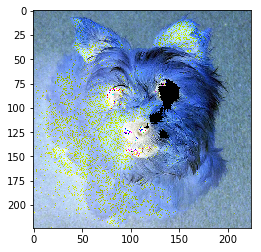

Step 4/224, P=0.3160509467124939


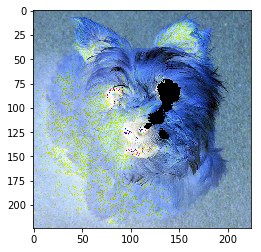

...


In [31]:
h = analyze(X, model.predict(X), explanations, 224, 2)